# Thrombolysis choice model: accuracy measurement

**CAUTION: These results use artificial patients, where the thrombolysis use and outcome in the saved data were predicted from a model trained on real patients. These results are indicative of results obtained using real patients, but are not suitable to use for drawing any clinical conclusions.**

In the notebook, we fit an XGBoost model to predict use of thrombolysis for patients attending different hospitals, and assess accuracy in a number of different ways.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier

## Load and prepare data

In [2]:
# Load data
data = pd.read_csv('./data/artificial_ml_data.csv', low_memory=False)

# Define fields to use for thrombolysis prediction
X_thrombolysis_fields = [
            'stroke_team',
            'onset_to_arrival_time',
            'onset_during_sleep',
            'arrival_to_scan_time',
            'infarction',
            'stroke_severity',
            'precise_onset_known',
            'prior_disability',
            'afib_anticoagulant',
            'age',
        ]

# Get list of stroke teams
stroke_teams = data['stroke_team'].unique()
stroke_teams.sort()

# Split data into train and test sets
stratificiation = data['stroke_team'].map(str) + '-' + data['thrombolysis'].map(str)
X_train, X_test, y_train, y_test = train_test_split(
    data[X_thrombolysis_fields],
    data['thrombolysis'],
    test_size=0.25, 
    stratify=stratificiation,
    random_state=42)

# One-hot encode stroke team
encoder = OneHotEncoder(categories=[stroke_teams], sparse=False)
encoder.fit(X_train[['stroke_team']])
one_hot_encoded = encoder.transform(X_train[['stroke_team']])
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=stroke_teams, index=X_train.index)
X_one_hot_train = pd.concat([X_train, one_hot_encoded_df], axis=1)
X_one_hot_train.drop('stroke_team', axis=1, inplace=True)
encoder.fit(X_test[['stroke_team']])
one_hot_encoded = encoder.transform(X_test[['stroke_team']])
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=stroke_teams, index=X_test.index)
X_one_hot_test = pd.concat([X_test, one_hot_encoded_df], axis=1)
X_one_hot_test.drop('stroke_team', axis=1, inplace=True)

## Function to calculate accuracy scores

In [3]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified
    11) balanced accuracy: average of sensitivity and specificity        
    12) positive likelihood: increased probability of true +ve if test +ve
    13) negative likelihood: reduced probability of true +ve if test -ve
    14) false positive rate: proportion of false +ves in true -ve patients
    15) false negative rate: proportion of false -ves in true +ve patients
    16) true positive rate: Same as recall
    17) true negative rate: Same as specificity
    18) positive predictive value: chance of true +ve if test +ve
    19) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    false_negatives = (predicted_negatives == 1) & (observed_negatives == 0)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)

    balanced_accuracy = (sensitivity + specificity) / 2
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                            (np.sum(true_positives) + np.sum(false_positives)))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                            (np.sum(true_negatives) + np.sum(false_negatives)))

    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['balanced_accuracy'] = balanced_accuracy
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

## Fit model


In [4]:
model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5)
model.fit(X_one_hot_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Get accuracy measurements

In [5]:
# Get predictions
y_pred_prob = model.predict_proba(X_one_hot_test)[:, 1]
y_pred = y_pred_prob > 0.5

### Get accuracy measurements

In [6]:
accuracy = calculate_accuracy(y_test, y_pred)
accuracy_df = pd.DataFrame.from_dict(accuracy, orient='index', columns=['accuracy'])
accuracy_df.round(3)

,accuracy
observed_positive_rate,0.268
observed_negative_rate,0.732
predicted_positive_rate,0.247
predicted_negative_rate,0.753
accuracy,0.842
precision,0.723
recall,0.666
f1,0.694
sensitivity,0.666
specificity,0.907


### Get Receiver operating characteristic curve, with sensitivity and specificity

In [7]:
# Get ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc:0.3f}')

ROC AUC: 0.786


In [8]:
# Get ROC curve for plotting
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# Get sensitivity and specificity
sensitivity = tpr
specificity = 1 - fpr

In [9]:
# Get intersection of sensitivity and specificity
intersection = np.argmin(np.abs(sensitivity - specificity))
# Get optimal threshold
optimal_threshold = thresholds[intersection]
# Get optimal sensitivity and specificity
optimal_sens_spec = (sensitivity[intersection] + specificity[intersection]) /2

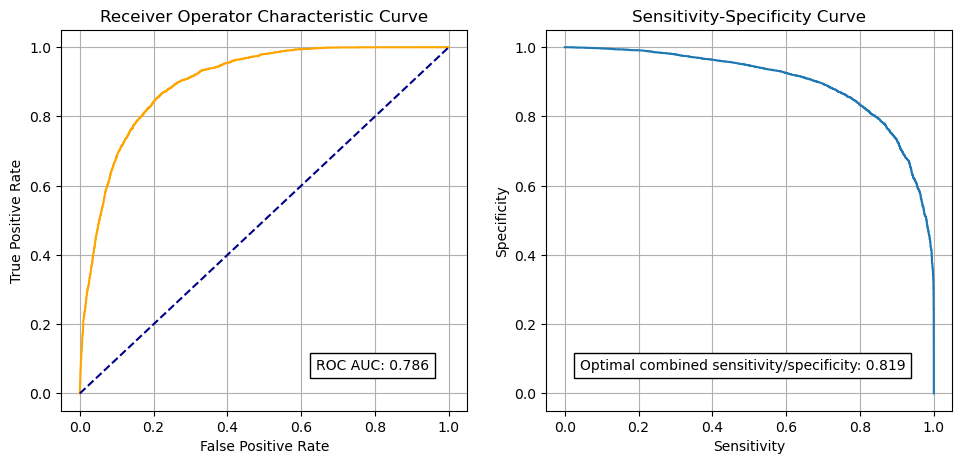

In [10]:
fig = plt.figure(figsize=(10,5))

# Plot ROC
ax1 = fig.add_subplot(121)
ax1.plot(fpr, tpr, color='orange')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic Curve')
text = f'ROC AUC: {roc_auc:0.3f}'
ax1.text(0.64,0.07, text, bbox=dict(facecolor='white', edgecolor='black'))
plt.grid(True)

# Plot sensitivity-specificity
ax2 = fig.add_subplot(122)
ax2.plot(sensitivity, specificity)
ax2.set_xlabel('Sensitivity')
ax2.set_ylabel('Specificity')
ax2.set_title('Sensitivity-Specificity Curve')
text = f'Optimal combined sensitivity/specificity: {optimal_sens_spec:0.3f}'
ax2.text(0.04,0.07, text, bbox=dict(facecolor='white', edgecolor='black'))

plt.grid(True)

plt.tight_layout(pad=2)
plt.show()

## Compare actual and predicted thrombolysis use for stroke teams

We compare predicted and observed use of thrombolysis for each stroke team.

In [11]:
comparison = pd.DataFrame()
comparison['stroke_team'] = X_test['stroke_team']
comparison['thrombolysis'] = y_test
comparison['prediction'] = y_pred
comparison['probability'] = y_pred_prob
# Get groupby mean for each stroke team
stroke_team_comparison = comparison.groupby('stroke_team').mean().round(3)

Fit a regression line to predicted vs observed thrombolylis, and plot results.

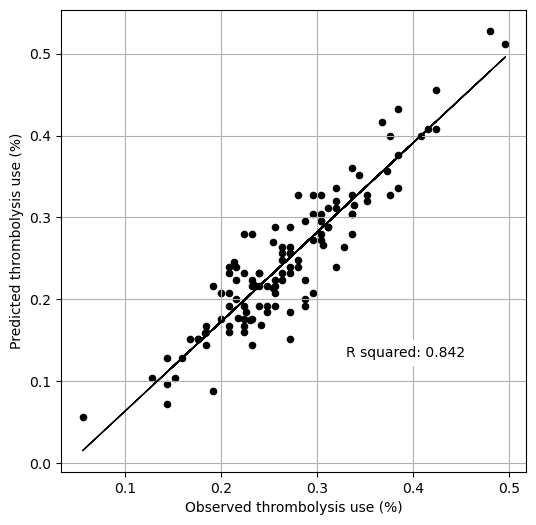

In [12]:
# Fit a regression line to the x2 points
x = stroke_team_comparison['thrombolysis']
y = stroke_team_comparison['prediction']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
r_square = r_value ** 2
thrombolysis_pred = intercept + (x * slope)

# Plot the observed vs predicted rates
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(x, y, c='k', s=20)
ax1.plot (x, thrombolysis_pred, color = 'k', linewidth=1)
text = f'R squared: {r_square:.3f}'
ax1.text(0.33,0.13, text, bbox=dict(facecolor='white', edgecolor='white'))
ax1.set_xlabel('Observed thrombolysis use (%)')
ax1.set_ylabel('Predicted thrombolysis use (%)')
plt.grid()

plt.show()

In [13]:
average_difference = np.mean(y - x)
print(f'Average difference between observed and predicted thrombolysis use: {average_difference:.3f}')

average_absolute_difference = np.mean(np.abs(y - x))
print(f'Average absolute difference between observed and predicted thrombolysis use: {average_absolute_difference:.3f}')

Average difference between observed and predicted thrombolysis use: -0.021
Average absolute difference between observed and predicted thrombolysis use: 0.033


## Plot a model calibration curve

The calibration curve compared the predicted probability of receiving thrombolysis, with the observed proportion of patients receiving thrombolysis. Results are compared using bins of predicted probability. A well-calibrated model has good alignment between prediction probabilities for patients and the proportion of patients who actually received thrombolysis. 

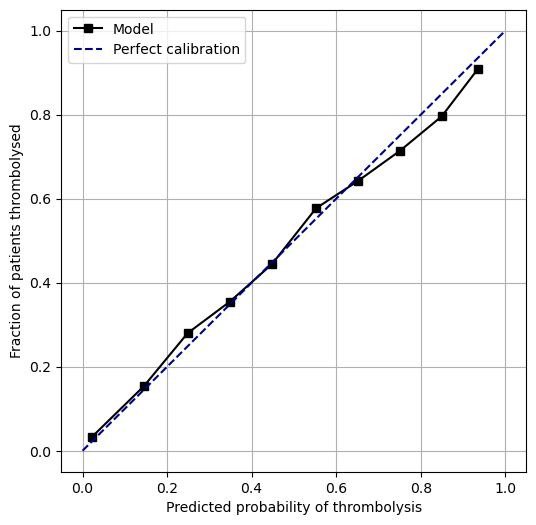

In [14]:
# Bin data with numpy digitize (this will assign a bin to each case)
step = 0.10
bins = np.arange(step, 1+step, step)
digitized = np.digitize(y_pred_prob, bins)
# Store in dataframe
reliability_df = pd.DataFrame()
reliability_df['probability'] = y_pred_prob
reliability_df['bin'] = digitized
reliability_df['thrombolysis'] = y_test.values
# Calculate mean of predicted probability of thrombolysis in each bin
confidence = reliability_df.groupby('bin').mean()['probability']
fraction_positive = reliability_df.groupby('bin').mean()['thrombolysis']

# Plot reliability curve
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.plot(confidence, fraction_positive, 's-', color='k', label='Model')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Perfect calibration')
ax1.set_xlabel('Predicted probability of thrombolysis')
ax1.set_ylabel('Fraction of patients thrombolysed')
ax1.legend()
plt.grid()

plt.show()